In [1]:
# 데이터셋 압축 풀기
# !unzip -uq "roi_dataset.zip" # 폴더 이름 roi

In [4]:
# 라이브러리 불러오기

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import Reshape, Permute, Activation, Input, merge
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

import sys
import os
import glob
import cv2, numpy as np

In [5]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sessions = tf. Session(config=config)

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.applications.mobilenet_v2 import MobileNetV2  
from keras.applications.mobilenet import MobileNet

input_shape = (250, 250, 3)
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# 미세 조정
base_model.trainable=True

set_trainable=False
for layer in base_model.layers:
    if layer.name == 'out_relu': # 쌓은 층 직전까지 동결
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

x = Conv2D(1, (1, 1), activation='relu')(base_model.output)
x = Flatten()(x)
dropout = Dropout(0.4)(x)
output = Dense(3, activation='softmax', name='predictions')(dropout)
model = Model(inputs=base_model.input, output=output)

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

model.summary()

/home/ubuntu/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 251, 251, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 125, 125, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 125, 125, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

/home/ubuntu/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`


In [ ]:
# ImagedataGenerator 불러오기
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# train data load 
train_set = train_datagen.flow_from_directory('roi/train/', 
                                              target_size=(250, 250),  
                                              class_mode='categorical', 
                                              batch_size=32)

# val data load 
val_set = val_datagen.flow_from_directory('roi/val/', 
                                            target_size=(250, 250), 
                                            class_mode='categorical', 
                                            batch_size=32) 

# test data load
test_set = test_datagen.flow_from_directory('roi/test/',
                                           target_size=(250, 250),
                                           class_mode='categorical',
                                           batch_size=32,
                                           shuffle=False)

# fit model
history = model.fit_generator(train_set,
                              epochs = 10,
                              steps_per_epoch=128,
                             validation_data = val_set)

Found 32077 images belonging to 3 classes.
Found 3806 images belonging to 3 classes.
Found 4205 images belonging to 3 classes.
Epoch 1/10
128/128 [==============================] - 22s 170ms/step - loss: 1.1120 - accuracy: 0.4015 - val_loss: 1.1076 - val_accuracy: 0.4115
Epoch 2/10
128/128 [==============================] - 20s 154ms/step - loss: 1.0804 - accuracy: 0.4175 - val_loss: 1.0920 - val_accuracy: 0.4138
Epoch 3/10
128/128 [==============================] - 19s 152ms/step - loss: 1.0796 - accuracy: 0.4150 - val_loss: 1.1105 - val_accuracy: 0.4122
Epoch 4/10
128/128 [==============================] - 20s 153ms/step - loss: 1.0753 - accuracy: 0.4053 - val_loss: 1.0834 - val_accuracy: 0.4080
Epoch 5/10
128/128 [==============================] - 20s 155ms/step - loss: 1.0292 - accuracy: 0.4189 - val_loss: 1.0914 - val_accuracy: 0.4133
Epoch 6/10
128/128 [==============================] - 20s 154ms/step - loss: 0.9717 - accuracy: 0.4561 - val_loss: 1.0094 - val_accuracy: 0.3865
Epo

In [8]:
print(test_set.class_indices)

{'E01': 0, 'E02': 1, 'E03': 2}


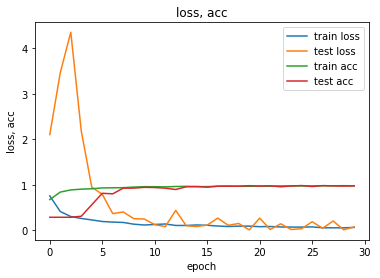

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('loss, acc')
plt.xlabel('epoch')
plt.ylabel('loss, acc')
plt.legend(['train loss', 'test loss', 'train acc', 'test acc'])
plt.show()

In [6]:
# model 검증
from sklearn.metrics import classification_report

pred = model.predict_generator(test_set)

val_preds = np.argmax(pred, axis=-1)
val_trues = test_set.classes

print(classification_report(val_trues,val_preds))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1771
           1       0.99      0.96      0.97      1344
           2       0.94      0.99      0.96      1090

   micro avg       0.97      0.97      0.97      4205
   macro avg       0.97      0.97      0.97      4205
weighted avg       0.97      0.97      0.97      4205



In [ ]:
pred = model.predict_generator(pred_set)


val_preds = np.argmax(pred, axis=-1)
val_trues = pred_set.classes
cm = metrics.confusion_matrix(val_trues, val_preds)


labels = pred_set1.class_indices.keys()
precisions, recall, f1_score, _ = metrics.precision_recall_fscore_support(val_trues, val_preds, labels=labels)

In [7]:
model.save('./save/cnn0521(imagegenerator, 250, haar cascade).h5')
print('모델 저장이 완료되었습니다.')

모델 저장이 완료되었습니다.
